In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.stats import normaltest, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [70]:
# Load the filtered data
data = pd.read_csv('../../data/processed/ProSeq_raw_filtered.csv')
print(f"Data shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())

# Extract the ratio column for analysis
ratio_data = data['log(CPM_TUMOR/CPM_SPLEEN)'].values.reshape(-1, 1)
ratio_1d = data['log(CPM_TUMOR/CPM_SPLEEN)'].values

print(f"\nBasic statistics for CPM_TUMOR/CPM_SPLEEN ratio:")
print(f"Mean: {np.mean(ratio_1d):.4f}")
print(f"Median: {np.median(ratio_1d):.4f}")
print(f"Std: {np.std(ratio_1d):.4f}")
print(f"Skewness: {stats.skew(ratio_1d):.4f}")
print(f"Kurtosis: {stats.kurtosis(ratio_1d):.4f}")


Data shape: (8307, 8)

First few rows:
  GeneID       Ensembl_ID  CPM_TUMOR  CPM_SPLEEN  \
0   DPM1  ENSG00000000419  61.274627   47.583513   
1  SCYL3  ENSG00000000457  21.703534   31.948930   
2  FUCA2  ENSG00000001036  37.855000   31.797871   
3   GCLC  ENSG00000001084  16.151467   17.447288   
4   NFYA  ENSG00000001167  22.410160   30.815989   

                                              ProSeq Chr  \
0  AAGCTGCACAGTCGAGCCTGCGGCTCCGCAGCCGAATAGAGCGGAA...  20   
1  GGGGGCAAAACTACTGCATTAATATTAAAATTTTCAAATATTACTT...   1   
2  TCCCAAAGTGTTGGGATTACAGGAGTGAGCCACCGCGCCCGGCCCA...   6   
3  AAGGCAAACTTAAGAGATTGTAGTAACCACAGCAGGCATAATCAGC...   6   
4  GGGAAGGGCTCCGGATCCGACCCTGGTAGGTGGGGAGCAGCGGACC...   6   

   CPM_TUMOR/CPM_SPLEEN  log(CPM_TUMOR/CPM_SPLEEN)  
0              1.287728                   0.252880  
1              0.679320                  -0.386664  
2              1.190489                   0.174364  
3              0.925729                  -0.077173  
4              0.72722

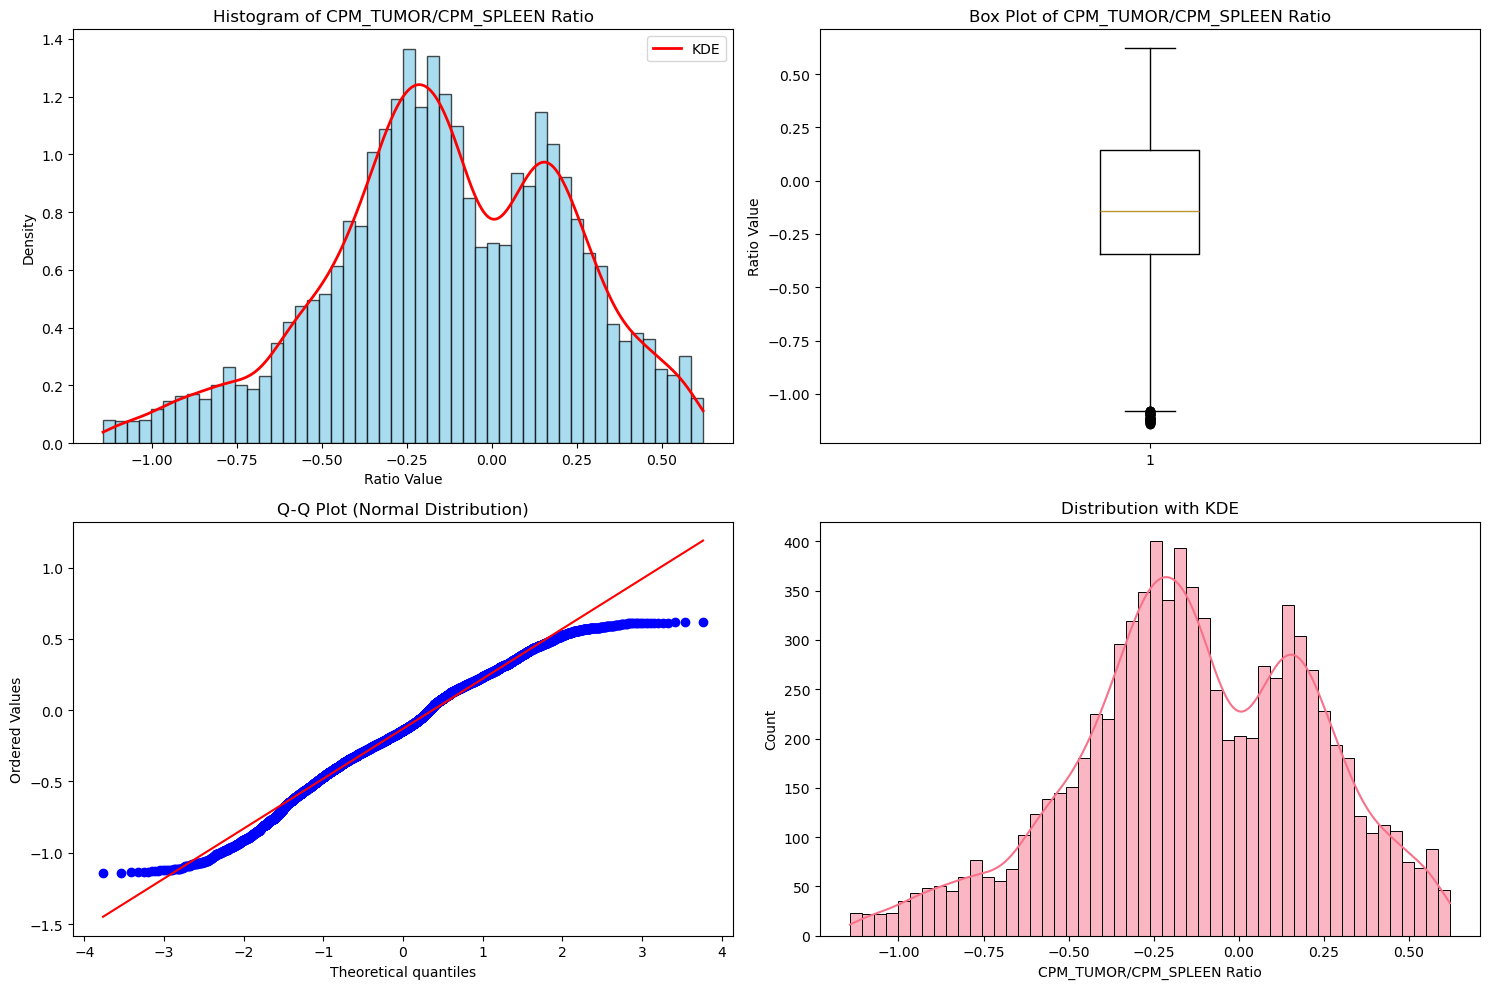

In [71]:
# Visualize the distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
axes[0, 0].hist(ratio_1d, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram of CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_xlabel('Ratio Value')
axes[0, 0].set_ylabel('Density')

# Add KDE overlay
from scipy.stats import gaussian_kde
kde = gaussian_kde(ratio_1d)
x_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000)
axes[0, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(ratio_1d)
axes[0, 1].set_title('Box Plot of CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Ratio Value')

# Q-Q plot
stats.probplot(ratio_1d, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution)')

# Seaborn distribution plot
sns.histplot(ratio_1d, kde=True, ax=axes[1, 1], bins=50)
axes[1, 1].set_title('Distribution with KDE')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')

plt.tight_layout()
plt.show()


In [72]:
# Fit GMM models with different numbers of components
n_components_range = range(1, 10)
models = {}
aic_scores = []
bic_scores = []
log_likelihoods = []

print("Fitting GMM models with different numbers of components...")
print("\nComponent\tAIC\t\tBIC\t\tLog-Likelihood")
print("-" * 60)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(ratio_data)
    
    models[n_components] = gmm
    aic = gmm.aic(ratio_data)
    bic = gmm.bic(ratio_data)
    log_likelihood = gmm.score(ratio_data) * len(ratio_data)
    
    aic_scores.append(aic)
    bic_scores.append(bic)
    log_likelihoods.append(log_likelihood)
    
    print(f"{n_components}\t\t{aic:.2f}\t\t{bic:.2f}\t\t{log_likelihood:.2f}")

# Find optimal number of components
optimal_aic = n_components_range[np.argmin(aic_scores)]
optimal_bic = n_components_range[np.argmin(bic_scores)]

print(f"\nOptimal number of components:")
print(f"Based on AIC: {optimal_aic}")
print(f"Based on BIC: {optimal_bic}")


Fitting GMM models with different numbers of components...

Component	AIC		BIC		Log-Likelihood
------------------------------------------------------------
1		6242.16		6256.21		-3119.08
2		6176.06		6211.19		-3083.03
3		5833.32		5889.52		-2908.66
4		5883.70		5960.98		-2930.85
5		5675.21		5773.55		-2823.60
6		5664.22		5783.65		-2815.11
7		5676.55		5817.05		-2818.28
8		5671.95		5833.52		-2812.97
9		5657.44		5840.09		-2802.72

Optimal number of components:
Based on AIC: 9
Based on BIC: 5


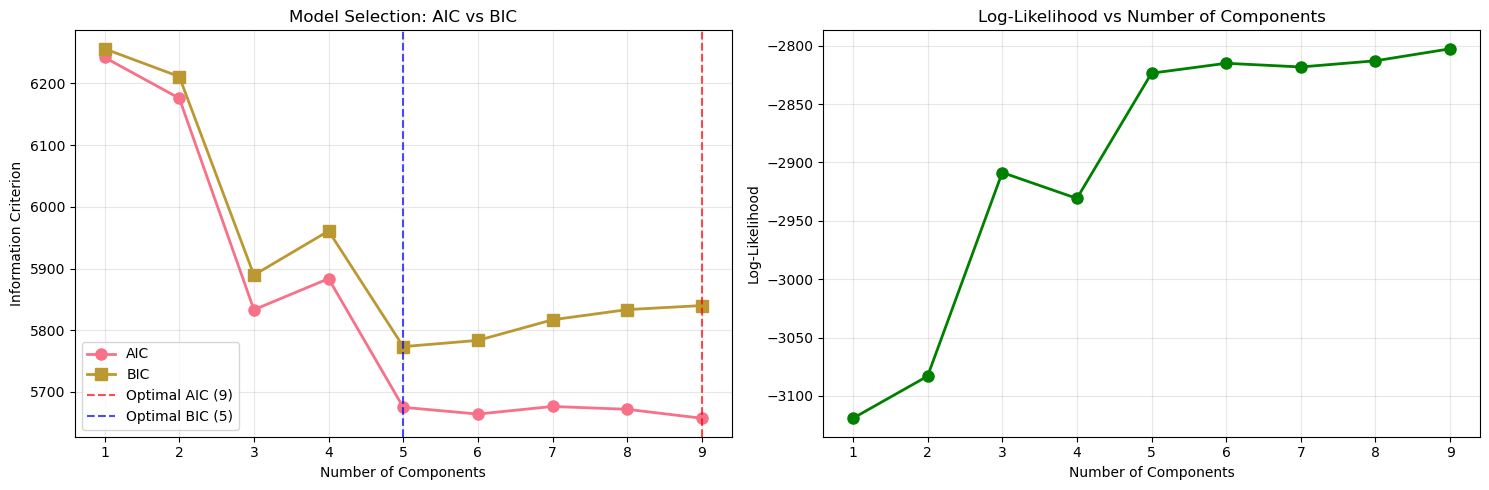

In [73]:
# Plot model selection criteria
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# AIC and BIC comparison
ax1.plot(n_components_range, aic_scores, 'o-', label='AIC', linewidth=2, markersize=8)
ax1.plot(n_components_range, bic_scores, 's-', label='BIC', linewidth=2, markersize=8)
ax1.axvline(x=optimal_aic, color='red', linestyle='--', alpha=0.7, label=f'Optimal AIC ({optimal_aic})')
ax1.axvline(x=optimal_bic, color='blue', linestyle='--', alpha=0.7, label=f'Optimal BIC ({optimal_bic})')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Information Criterion')
ax1.set_title('Model Selection: AIC vs BIC')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log-likelihood
ax2.plot(n_components_range, log_likelihoods, 'o-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title('Log-Likelihood vs Number of Components')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [74]:
# Likelihood Ratio Test for 5-component model
from scipy.stats import chi2

# Calculate likelihood ratio test statistic
gmm_1 = models[1]
gmm_5 = models[5]

ll_1 = gmm_1.score(ratio_data) * len(ratio_data)
ll_5 = gmm_5.score(ratio_data) * len(ratio_data)
lr_statistic = 2 * (ll_5 - ll_1)

# Degrees of freedom difference (5-component has 12 more parameters than 1-component)
# Each component adds 3 parameters (mean, variance, weight), so 4 additional components = 12 parameters
df = 12
p_value = 1 - chi2.cdf(lr_statistic, df)

print("=== Likelihood Ratio Test ===")
print(f"H0: Data is unimodal (1 component)")
print(f"H1: Data has multiple components (5 components)")
print(f"\nLog-likelihood (1-component): {ll_1:.2f}")
print(f"Log-likelihood (5-component): {ll_5:.2f}")
print(f"LR statistic: {lr_statistic:.2f}")
print(f"Degrees of freedom: {df}")
print(f"P-value: {p_value:.2e}")

alpha = 0.05
if p_value < alpha:
    print(f"\n✓ REJECT H0 at α = {alpha}")
    print("✓ Evidence for MULTIPLE COMPONENTS (5-component model)")
else:
    print(f"\n✗ FAIL TO REJECT H0 at α = {alpha}")
    print("✗ No strong evidence for multiple components")


=== Likelihood Ratio Test ===
H0: Data is unimodal (1 component)
H1: Data has multiple components (5 components)

Log-likelihood (1-component): -3119.08
Log-likelihood (5-component): -2823.60
LR statistic: 590.95
Degrees of freedom: 12
P-value: 0.00e+00

✓ REJECT H0 at α = 0.05
✓ Evidence for MULTIPLE COMPONENTS (5-component model)


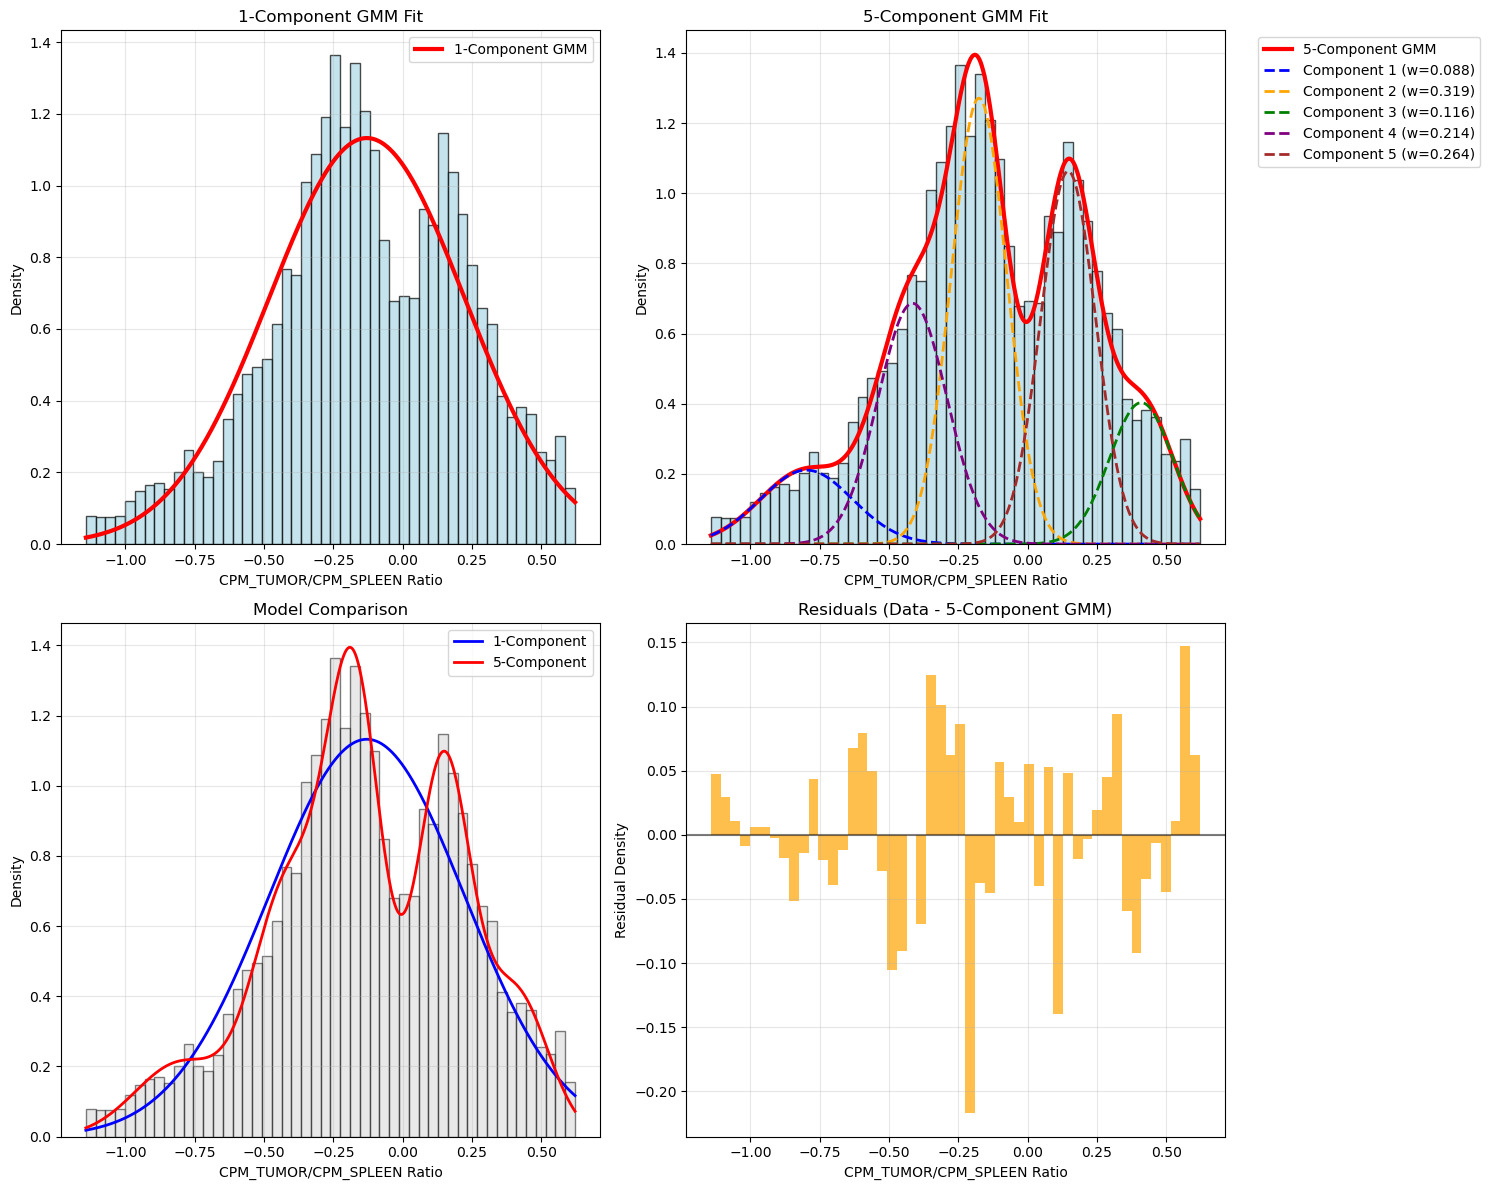

In [75]:
# Visualize GMM fits
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

x_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000).reshape(-1, 1)
x_range_1d = x_range.flatten()

# 1-Component Model
axes[0, 0].hist(ratio_1d, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
gmm1_pdf = np.exp(gmm_1.score_samples(x_range))
axes[0, 0].plot(x_range_1d, gmm1_pdf, 'r-', linewidth=3, label='1-Component GMM')
axes[0, 0].set_title('1-Component GMM Fit')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 5-Component Model
axes[0, 1].hist(ratio_1d, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
gmm5_pdf = np.exp(gmm_5.score_samples(x_range))
axes[0, 1].plot(x_range_1d, gmm5_pdf, 'r-', linewidth=3, label='5-Component GMM')

# Plot individual components
colors = ['blue', 'orange', 'green', 'purple', 'brown']
responsibilities_5 = gmm_5.predict_proba(x_range)
for i in range(5):
    component_pdf = responsibilities_5[:, i] * gmm5_pdf
    axes[0, 1].plot(x_range_1d, component_pdf, '--', linewidth=2, color=colors[i],
                   label=f'Component {i+1} (w={gmm_5.weights_[i]:.3f})')

axes[0, 1].set_title('5-Component GMM Fit')
axes[0, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# Comparison of both models
axes[1, 0].hist(ratio_1d, bins=50, density=True, alpha=0.5, color='lightgray', edgecolor='black')
axes[1, 0].plot(x_range_1d, gmm1_pdf, 'b-', linewidth=2, label='1-Component')
axes[1, 0].plot(x_range_1d, gmm5_pdf, 'r-', linewidth=2, label='5-Component')
axes[1, 0].set_title('Model Comparison')
axes[1, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals (Data - 5-component fit)
hist_counts, bin_edges = np.histogram(ratio_1d, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
gmm5_at_bins = np.exp(gmm_5.score_samples(bin_centers.reshape(-1, 1)))
residuals = hist_counts - gmm5_at_bins

axes[1, 1].bar(bin_centers, residuals, width=np.diff(bin_edges)[0], alpha=0.7, color='orange')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 1].set_title('Residuals (Data - 5-Component GMM)')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Residual Density')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [76]:
# Summary of findings
print("=" * 60)
print("5-COMPONENT GAUSSIAN MIXTURE MODEL ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nData characteristics:")
print(f"  • Sample size: {len(ratio_1d):,}")
print(f"  • Mean ratio: {np.mean(ratio_1d):.4f}")
print(f"  • Standard deviation: {np.std(ratio_1d):.4f}")
print(f"  • Skewness: {stats.skew(ratio_1d):.4f}")
print(f"  • Kurtosis: {stats.kurtosis(ratio_1d):.4f}")

# Calculate improvement metrics
aic_improvement = gmm_1.aic(ratio_data) - gmm_5.aic(ratio_data)
bic_improvement = gmm_1.bic(ratio_data) - gmm_5.bic(ratio_data)

print(f"\nModel selection results:")
print(f"  • Optimal components (AIC): {optimal_aic}")
print(f"  • Optimal components (BIC): {optimal_bic}")
print(f"  • AIC improvement (5 vs 1): {aic_improvement:.2f}")
print(f"  • BIC improvement (5 vs 1): {bic_improvement:.2f}")

print(f"\n5-Component Model Performance:")
print(f"  • AIC: {gmm_5.aic(ratio_data):.2f}")
print(f"  • BIC: {gmm_5.bic(ratio_data):.2f}")
print(f"  • Log-likelihood: {gmm_5.score(ratio_data) * len(ratio_data):.2f}")

print(f"\nLikelihood ratio test:")
print(f"  • LR statistic: {lr_statistic:.2f}")
print(f"  • P-value: {p_value:.2e}")
print(f"  • Result: {'MULTIPLE COMPONENTS' if p_value < 0.05 else 'UNIMODAL'} (α = 0.05)")

# Final conclusion
evidence_count = 0
if aic_improvement > 0: evidence_count += 1
if bic_improvement > 0: evidence_count += 1  
if p_value < 0.05: evidence_count += 1

print(f"\nCONCLUSION:")
if evidence_count >= 2:
    print(f"  ✓ STRONG EVIDENCE FOR MULTIPLE COMPONENTS")
    print(f"  ✓ The CPM_TUMOR/CPM_SPLEEN ratio data is best described by a 5-component model")
    print(f"  ✓ This suggests distinct expression patterns in the tumor-to-spleen ratio")
elif evidence_count == 1:
    print(f"  ⚠ WEAK EVIDENCE FOR MULTIPLE COMPONENTS")
    print(f"  ⚠ Some support for complexity, but not conclusive")
else:
    print(f"  ✗ NO STRONG EVIDENCE FOR MULTIPLE COMPONENTS")
    print(f"  ✗ Data appears to be unimodal")

print("\n" + "=" * 60)


5-COMPONENT GAUSSIAN MIXTURE MODEL ANALYSIS SUMMARY

Data characteristics:
  • Sample size: 8,307
  • Mean ratio: -0.1294
  • Standard deviation: 0.3522
  • Skewness: -0.2612
  • Kurtosis: -0.2266

Model selection results:
  • Optimal components (AIC): 9
  • Optimal components (BIC): 5
  • AIC improvement (5 vs 1): 566.95
  • BIC improvement (5 vs 1): 482.65

5-Component Model Performance:
  • AIC: 5675.21
  • BIC: 5773.55
  • Log-likelihood: -2823.60

Likelihood ratio test:
  • LR statistic: 590.95
  • P-value: 0.00e+00
  • Result: MULTIPLE COMPONENTS (α = 0.05)

CONCLUSION:
  ✓ STRONG EVIDENCE FOR MULTIPLE COMPONENTS
  ✓ The CPM_TUMOR/CPM_SPLEEN ratio data is best described by a 5-component model
  ✓ This suggests distinct expression patterns in the tumor-to-spleen ratio



In [77]:
# Function to get component probabilities for any ratio value
def get_component_probabilities(ratio_value, gmm_model):
    """
    Get the probability of a ratio value belonging to each component
    
    Parameters:
    ratio_value: float or array-like, the CPM_TUMOR/CPM_SPLEEN ratio value(s)
    gmm_model: fitted GaussianMixture model
    
    Returns:
    probabilities: array of probabilities for each component
    """
    # Ensure input is in the right shape
    if isinstance(ratio_value, (int, float)):
        ratio_value = np.array([[ratio_value]])
    else:
        ratio_value = np.array(ratio_value).reshape(-1, 1)
    
    # Get probabilities
    probabilities = gmm_model.predict_proba(ratio_value)
    
    return probabilities

# Specific function for 5-component model
def get_5component_probabilities(ratio_value):
    """
    Get the probability of a ratio value belonging to each of the 5 components
    
    Parameters:
    ratio_value: float or array-like, the CPM_TUMOR/CPM_SPLEEN ratio value(s)
    
    Returns:
    probabilities: array of probabilities for each of the 5 components
    """
    return get_component_probabilities(ratio_value, gmm_5)

# Example usage with the 5-component model
print("=== 5-Component Probability Calculator ===")
print("Using the 5-component GMM model\n")

# Show component characteristics
print("Component characteristics:")
for i in range(5):
    print(f"Component {i+1}:")
    print(f"  Weight: {gmm_5.weights_[i]:.4f} ({gmm_5.weights_[i]*100:.1f}%)")
    print(f"  Mean: {gmm_5.means_[i][0]:.4f}")
    print(f"  Std: {np.sqrt(gmm_5.covariances_[i][0][0]):.4f}")

print("\n" + "-"*50)


=== 5-Component Probability Calculator ===
Using the 5-component GMM model

Component characteristics:
Component 1:
  Weight: 0.0880 (8.8%)
  Mean: -0.7981
  Std: 0.1665
Component 2:
  Weight: 0.3189 (31.9%)
  Mean: -0.1758
  Std: 0.1001
Component 3:
  Weight: 0.1155 (11.6%)
  Mean: 0.4094
  Std: 0.1143
Component 4:
  Weight: 0.2139 (21.4%)
  Mean: -0.4154
  Std: 0.1243
Component 5:
  Weight: 0.2637 (26.4%)
  Mean: 0.1457
  Std: 0.0990

--------------------------------------------------


In [78]:
# Examples with specific ratio values
print("Examples with specific ratio values:\n")

# Test with some example values
test_ratios = [0.5, 0.8, 1.0, 1.2, 1.5]

for ratio in test_ratios:
    probs = get_5component_probabilities(ratio)
    print(f"Ratio = {ratio:.1f}:")
    for i in range(5):
        print(f"  P(Component {i+1}) = {probs[0][i]:.4f}")
    
    # Determine most likely component
    most_likely = np.argmax(probs[0]) + 1
    confidence = np.max(probs[0])
    print(f"  → Most likely: Component {most_likely} (confidence: {confidence:.4f})")
    print()

print("-"*50)


Examples with specific ratio values:

Ratio = 0.5:
  P(Component 1) = 0.0000
  P(Component 2) = 0.0000
  P(Component 3) = 0.9941
  P(Component 4) = 0.0000
  P(Component 5) = 0.0059
  → Most likely: Component 3 (confidence: 0.9941)

Ratio = 0.8:
  P(Component 1) = 0.0000
  P(Component 2) = 0.0000
  P(Component 3) = 1.0000
  P(Component 4) = 0.0000
  P(Component 5) = 0.0000
  → Most likely: Component 3 (confidence: 1.0000)

Ratio = 1.0:
  P(Component 1) = 0.0000
  P(Component 2) = 0.0000
  P(Component 3) = 1.0000
  P(Component 4) = 0.0000
  P(Component 5) = 0.0000
  → Most likely: Component 3 (confidence: 1.0000)

Ratio = 1.2:
  P(Component 1) = 0.0000
  P(Component 2) = 0.0000
  P(Component 3) = 1.0000
  P(Component 4) = 0.0000
  P(Component 5) = 0.0000
  → Most likely: Component 3 (confidence: 1.0000)

Ratio = 1.5:
  P(Component 1) = 0.0000
  P(Component 2) = 0.0000
  P(Component 3) = 1.0000
  P(Component 4) = 0.0000
  P(Component 5) = 0.0000
  → Most likely: Component 3 (confidence: 1

In [79]:
# Examples from actual data
print("Examples from actual data:\n")

# Get some random samples from the data
np.random.seed(42)
sample_indices = np.random.choice(len(ratio_1d), 10, replace=False)
sample_ratios = ratio_1d[sample_indices]

print("Sample data points:")
for i, ratio in enumerate(sample_ratios):
    probs = get_5component_probabilities(ratio)
    print(f"Data point {i+1}: Ratio = {ratio:.4f}")
    for j in range(5):
        print(f"  P(Component {j+1}) = {probs[0][j]:.4f}")
    
    # Determine most likely component
    most_likely = np.argmax(probs[0]) + 1
    confidence = np.max(probs[0])
    print(f"  → Component {most_likely} (confidence: {confidence:.4f})")
    print()

print("-"*50)


Examples from actual data:

Sample data points:
Data point 1: Ratio = -0.1910
  P(Component 1) = 0.0002
  P(Component 2) = 0.9009
  P(Component 3) = 0.0000
  P(Component 4) = 0.0966
  P(Component 5) = 0.0023
  → Component 2 (confidence: 0.9009)

Data point 2: Ratio = -0.3336
  P(Component 1) = 0.0047
  P(Component 2) = 0.3971
  P(Component 3) = 0.0000
  P(Component 4) = 0.5983
  P(Component 5) = 0.0000
  → Component 4 (confidence: 0.5983)

Data point 3: Ratio = -0.1623
  P(Component 1) = 0.0001
  P(Component 2) = 0.9298
  P(Component 3) = 0.0000
  P(Component 4) = 0.0639
  P(Component 5) = 0.0062
  → Component 2 (confidence: 0.9298)

Data point 4: Ratio = -0.2807
  P(Component 1) = 0.0015
  P(Component 2) = 0.6569
  P(Component 3) = 0.0000
  P(Component 4) = 0.3415
  P(Component 5) = 0.0001
  → Component 2 (confidence: 0.6569)

Data point 5: Ratio = -0.5392
  P(Component 1) = 0.1305
  P(Component 2) = 0.0036
  P(Component 3) = 0.0000
  P(Component 4) = 0.8659
  P(Component 5) = 0.0000


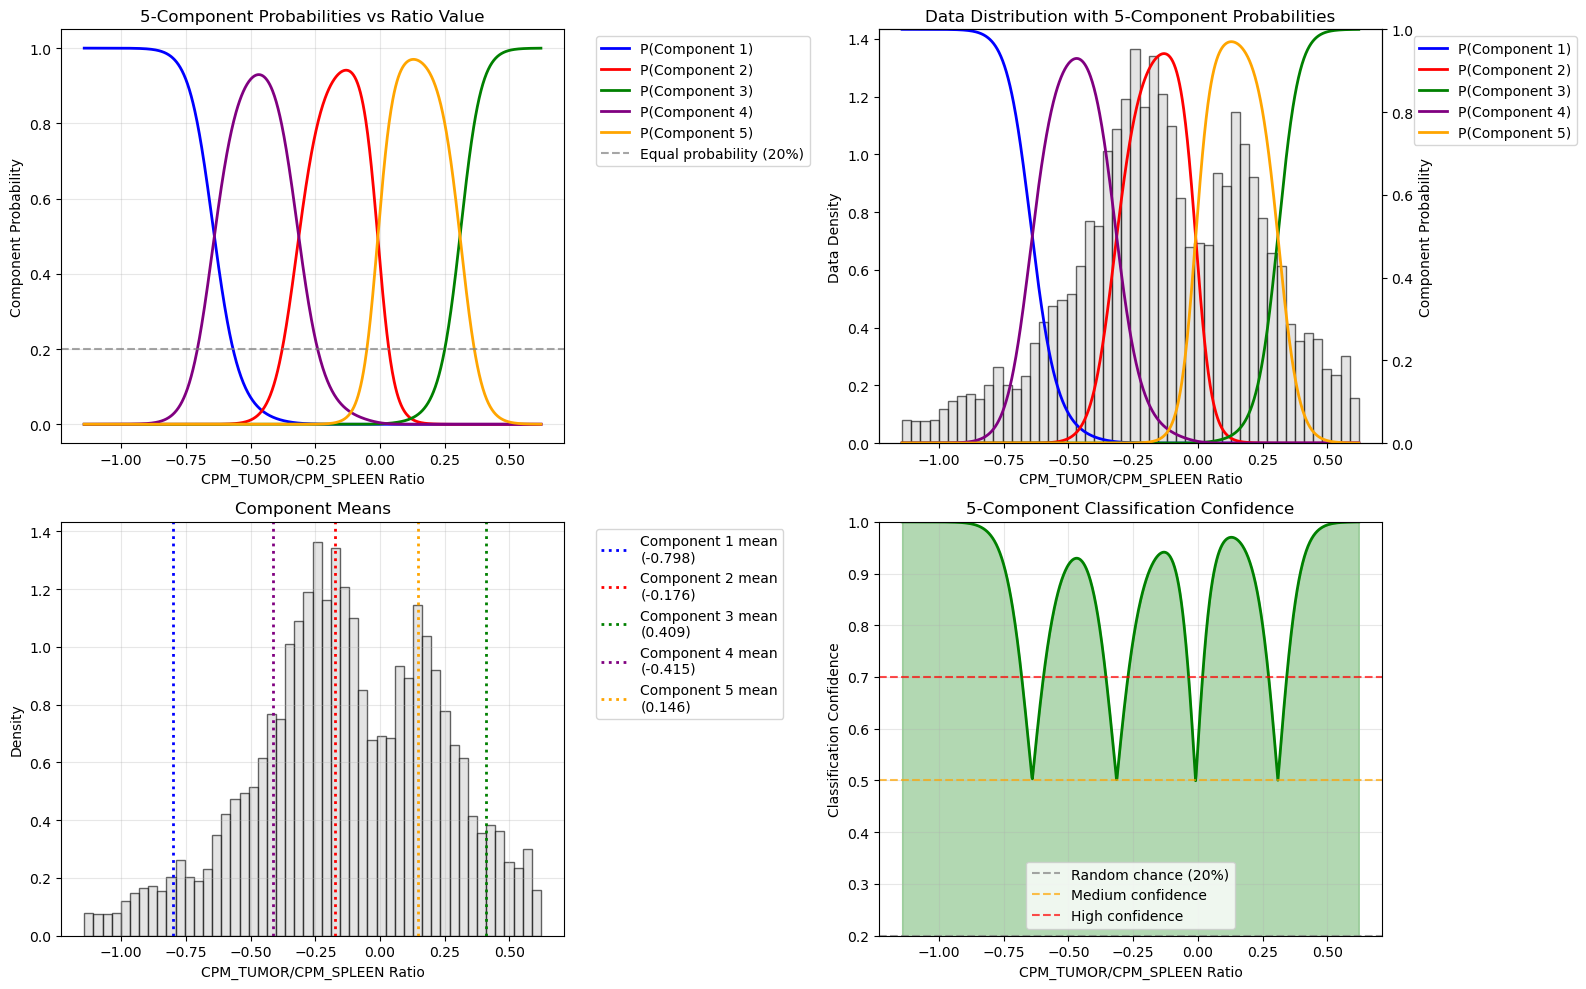

In [80]:
# Visualize component probabilities across the full range
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Create a range of ratio values for visualization
ratio_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000)
probs_range = get_5component_probabilities(ratio_range)

# Colors for 5 components
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Plot 1: Component probabilities vs ratio value
for i in range(5):
    axes[0, 0].plot(ratio_range, probs_range[:, i], color=colors[i], linewidth=2, 
                   label=f'P(Component {i+1})')
axes[0, 0].axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='Equal probability (20%)')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Component Probability')
axes[0, 0].set_title('5-Component Probabilities vs Ratio Value')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram with probability overlay
axes[0, 1].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')
ax_twin = axes[0, 1].twinx()
for i in range(5):
    ax_twin.plot(ratio_range, probs_range[:, i], color=colors[i], linewidth=2, 
                label=f'P(Component {i+1})')
ax_twin.set_ylabel('Component Probability')
ax_twin.set_ylim(0, 1)
axes[0, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Data Density')
axes[0, 1].set_title('Data Distribution with 5-Component Probabilities')
ax_twin.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 3: Component means visualization
axes[1, 0].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')
for i in range(5):
    axes[1, 0].axvline(x=gmm_5.means_[i][0], color=colors[i], linestyle=':', linewidth=2, 
                      label=f'Component {i+1} mean\n({gmm_5.means_[i][0]:.3f})')
axes[1, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Component Means')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confidence levels
confidence_levels = np.max(probs_range, axis=1)
axes[1, 1].plot(ratio_range, confidence_levels, 'g-', linewidth=2)
axes[1, 1].fill_between(ratio_range, confidence_levels, alpha=0.3, color='green')
axes[1, 1].axhline(y=0.2, color='gray', linestyle='--', alpha=0.7, label='Random chance (20%)')
axes[1, 1].axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium confidence')
axes[1, 1].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='High confidence')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Classification Confidence')
axes[1, 1].set_title('5-Component Classification Confidence')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0.2, 1.0)

plt.tight_layout()
plt.show()


In [81]:
# Practical utility: Classify new ratio values using 5-component model
def classify_ratio_5comp(ratio_value, confidence_threshold=0.5):
    """
    Classify a CPM_TUMOR/CPM_SPLEEN ratio using 5-component model and provide interpretation
    
    Parameters:
    ratio_value: float, the ratio to classify
    confidence_threshold: float, minimum confidence for reliable classification
    
    Returns:
    dict with classification results
    """
    probs = get_5component_probabilities(ratio_value)
    
    # Determine most likely component
    predicted_component = np.argmax(probs[0]) + 1
    confidence = np.max(probs[0])
    
    # Determine reliability
    if confidence >= confidence_threshold:
        reliability = "High"
    elif confidence >= 0.4:
        reliability = "Medium"
    else:
        reliability = "Low"
    
    # Component probabilities dictionary
    component_probs = {f'component_{i+1}_prob': probs[0][i] for i in range(5)}
    
    return {
        'ratio': ratio_value,
        'predicted_component': predicted_component,
        'confidence': confidence,
        'reliability': reliability,
        **component_probs,
        'interpretation': f"Ratio {ratio_value:.4f} → Component {predicted_component} ({confidence:.1%} confidence, {reliability.lower()} reliability)"
    }

print("=== 5-Component Classification Tool ===")
print("Use classify_ratio_5comp() to classify any new CPM_TUMOR/CPM_SPLEEN ratio\n")

# Examples
test_values = [0.6, 0.9, 1.1, 1.4]
print("Examples:")
for value in test_values:
    result = classify_ratio_5comp(value)
    print(f"• {result['interpretation']}")

print(f"\n5-Component Model Characteristics:")
component_order = np.argsort([gmm_5.means_[i][0] for i in range(5)])
for idx, i in enumerate(component_order):
    mean_val = gmm_5.means_[i][0]
    weight = gmm_5.weights_[i]
    print(f"• Component {i+1}: Mean ≈ {mean_val:.3f} (weight: {weight:.1%})")

# Provide interpretation of component types
print(f"\nComponent Interpretation (sorted by mean):")
sorted_components = [(i+1, gmm_5.means_[i][0], gmm_5.weights_[i]) for i in range(5)]
sorted_components.sort(key=lambda x: x[1])

component_labels = ['Very Low Expression', 'Low Expression', 'Moderate Expression', 'High Expression', 'Very High Expression']
for idx, (comp_num, mean, weight) in enumerate(sorted_components):
    print(f"• Component {comp_num}: {component_labels[idx]} (mean: {mean:.3f}, {weight:.1%} of data)")


=== 5-Component Classification Tool ===
Use classify_ratio_5comp() to classify any new CPM_TUMOR/CPM_SPLEEN ratio

Examples:
• Ratio 0.6000 → Component 3 (100.0% confidence, high reliability)
• Ratio 0.9000 → Component 3 (100.0% confidence, high reliability)
• Ratio 1.1000 → Component 3 (100.0% confidence, high reliability)
• Ratio 1.4000 → Component 3 (100.0% confidence, high reliability)

5-Component Model Characteristics:
• Component 1: Mean ≈ -0.798 (weight: 8.8%)
• Component 4: Mean ≈ -0.415 (weight: 21.4%)
• Component 2: Mean ≈ -0.176 (weight: 31.9%)
• Component 5: Mean ≈ 0.146 (weight: 26.4%)
• Component 3: Mean ≈ 0.409 (weight: 11.6%)

Component Interpretation (sorted by mean):
• Component 1: Very Low Expression (mean: -0.798, 8.8% of data)
• Component 4: Low Expression (mean: -0.415, 21.4% of data)
• Component 2: Moderate Expression (mean: -0.176, 31.9% of data)
• Component 5: High Expression (mean: 0.146, 26.4% of data)
• Component 3: Very High Expression (mean: 0.409, 11.6% 

In [82]:
# Save 5-component probabilities for all data points
print("=== Saving 5-Component Analysis Results ===")

# Get probabilities for all data points using 5-component model
all_5comp_probabilities = get_5component_probabilities(ratio_1d)

# Add probabilities to the original dataframe
data_with_5comp = data.copy()

# Add individual component probabilities
for i in range(5):
    data_with_5comp[f'Component_{i+1}_Probability'] = all_5comp_probabilities[:, i]

# Add predicted component (most likely)
data_with_5comp['Predicted_Component_5'] = np.argmax(all_5comp_probabilities, axis=1) + 1

# Add confidence (highest probability)
data_with_5comp['Classification_Confidence_5'] = np.max(all_5comp_probabilities, axis=1)

# Add reliability assessment for 5-component model
def assess_reliability_5comp(confidence):
    if confidence >= 0.5:
        return "High"
    elif confidence >= 0.4:
        return "Medium"
    else:
        return "Low"

data_with_5comp['Reliability_5'] = data_with_5comp['Classification_Confidence_5'].apply(assess_reliability_5comp)

# Add component interpretation
def get_component_interpretation_5comp(component_num):
    # Map component number to expression level based on sorted means
    sorted_components = [(i+1, gmm_5.means_[i][0]) for i in range(5)]
    sorted_components.sort(key=lambda x: x[1])
    
    component_labels = ['Very_Low_Expression', 'Low_Expression', 'Moderate_Expression', 'High_Expression', 'Very_High_Expression']
    
    for idx, (comp_num, mean) in enumerate(sorted_components):
        if comp_num == component_num:
            return component_labels[idx]
    return "Unknown"

data_with_5comp['Expression_Level'] = data_with_5comp['Predicted_Component_5'].apply(get_component_interpretation_5comp)

# Save to CSV
output_file_5comp = '../../data/processed/ProSeq_with_5component_analysis.csv'
data_with_5comp.to_csv(output_file_5comp, index=False)

print(f"✓ Saved 5-component analysis to: {output_file_5comp}")
print(f"✓ Dataset shape: {data_with_5comp.shape}")
print(f"✓ Added columns: {[col for col in data_with_5comp.columns if col not in data.columns]}")

# Display summary statistics
print(f"\n=== 5-Component Classification Summary ===")
component_counts = data_with_5comp['Predicted_Component_5'].value_counts().sort_index()
for comp in range(1, 6):
    count = component_counts.get(comp, 0)
    percentage = (count / len(data_with_5comp)) * 100
    mean_val = gmm_5.means_[comp-1][0]
    print(f"Component {comp}: {count:,} genes ({percentage:.1f}%) - Mean ratio: {mean_val:.3f}")

reliability_counts = data_with_5comp['Reliability_5'].value_counts()
print(f"\nClassification Reliability:")
for reliability in ['High', 'Medium', 'Low']:
    count = reliability_counts.get(reliability, 0)
    percentage = (count / len(data_with_5comp)) * 100
    print(f"{reliability}: {count:,} genes ({percentage:.1f}%)")





=== Saving 5-Component Analysis Results ===
✓ Saved 5-component analysis to: ../../data/processed/ProSeq_with_5component_analysis.csv
✓ Dataset shape: (8307, 17)
✓ Added columns: ['Component_1_Probability', 'Component_2_Probability', 'Component_3_Probability', 'Component_4_Probability', 'Component_5_Probability', 'Predicted_Component_5', 'Classification_Confidence_5', 'Reliability_5', 'Expression_Level']

=== 5-Component Classification Summary ===
Component 1: 657 genes (7.9%) - Mean ratio: -0.798
Component 2: 2,815 genes (33.9%) - Mean ratio: -0.176
Component 3: 873 genes (10.5%) - Mean ratio: 0.409
Component 4: 1,698 genes (20.4%) - Mean ratio: -0.415
Component 5: 2,264 genes (27.3%) - Mean ratio: 0.146

Classification Reliability:
High: 8,299 genes (99.9%)
Medium: 8 genes (0.1%)
Low: 0 genes (0.0%)


In [83]:
# Detailed Analysis of 5-Component Model
print("=" * 60)
print("5-COMPONENT MODEL DETAILED ANALYSIS")
print("=" * 60)

print("=== 5-Component Model Details ===")
# Sort components by mean for clearer interpretation
component_order = np.argsort([gmm_5.means_[i][0] for i in range(5)])
component_labels = ['Very Low Expression', 'Low Expression', 'Moderate Expression', 'High Expression', 'Very High Expression']

for idx, i in enumerate(component_order):
    print(f"Component {i+1} ({component_labels[idx]}):")
    print(f"  Weight: {gmm_5.weights_[i]:.4f} ({gmm_5.weights_[i]*100:.1f}%)")
    print(f"  Mean: {gmm_5.means_[i][0]:.4f}")
    print(f"  Std: {np.sqrt(gmm_5.covariances_[i][0][0]):.4f}")
    print()

print(f"Model Performance:")
print(f"AIC: {gmm_5.aic(ratio_data):.2f}")
print(f"BIC: {gmm_5.bic(ratio_data):.2f}")
print(f"Log-likelihood: {gmm_5.score(ratio_data) * len(ratio_data):.2f}")

# Compare with 1-component model
aic_improvement_5vs1 = gmm_1.aic(ratio_data) - gmm_5.aic(ratio_data)
bic_improvement_5vs1 = gmm_1.bic(ratio_data) - gmm_5.bic(ratio_data)

print(f"\nComparison with 1-component model:")
print(f"AIC improvement (5 vs 1): {aic_improvement_5vs1:.2f}")
print(f"BIC improvement (5 vs 1): {bic_improvement_5vs1:.2f}")

if aic_improvement_5vs1 > 0:
    print("✓ 5-component model is significantly better according to AIC")
else:
    print("✗ 1-component model is better according to AIC")
    
if bic_improvement_5vs1 > 0:
    print("✓ 5-component model is significantly better according to BIC")
else:
    print("✗ 1-component model is better according to BIC")


5-COMPONENT MODEL DETAILED ANALYSIS
=== 5-Component Model Details ===
Component 1 (Very Low Expression):
  Weight: 0.0880 (8.8%)
  Mean: -0.7981
  Std: 0.1665

Component 4 (Low Expression):
  Weight: 0.2139 (21.4%)
  Mean: -0.4154
  Std: 0.1243

Component 2 (Moderate Expression):
  Weight: 0.3189 (31.9%)
  Mean: -0.1758
  Std: 0.1001

Component 5 (High Expression):
  Weight: 0.2637 (26.4%)
  Mean: 0.1457
  Std: 0.0990

Component 3 (Very High Expression):
  Weight: 0.1155 (11.6%)
  Mean: 0.4094
  Std: 0.1143

Model Performance:
AIC: 5675.21
BIC: 5773.55
Log-likelihood: -2823.60

Comparison with 1-component model:
AIC improvement (5 vs 1): 566.95
BIC improvement (5 vs 1): 482.65
✓ 5-component model is significantly better according to AIC
✓ 5-component model is significantly better according to BIC


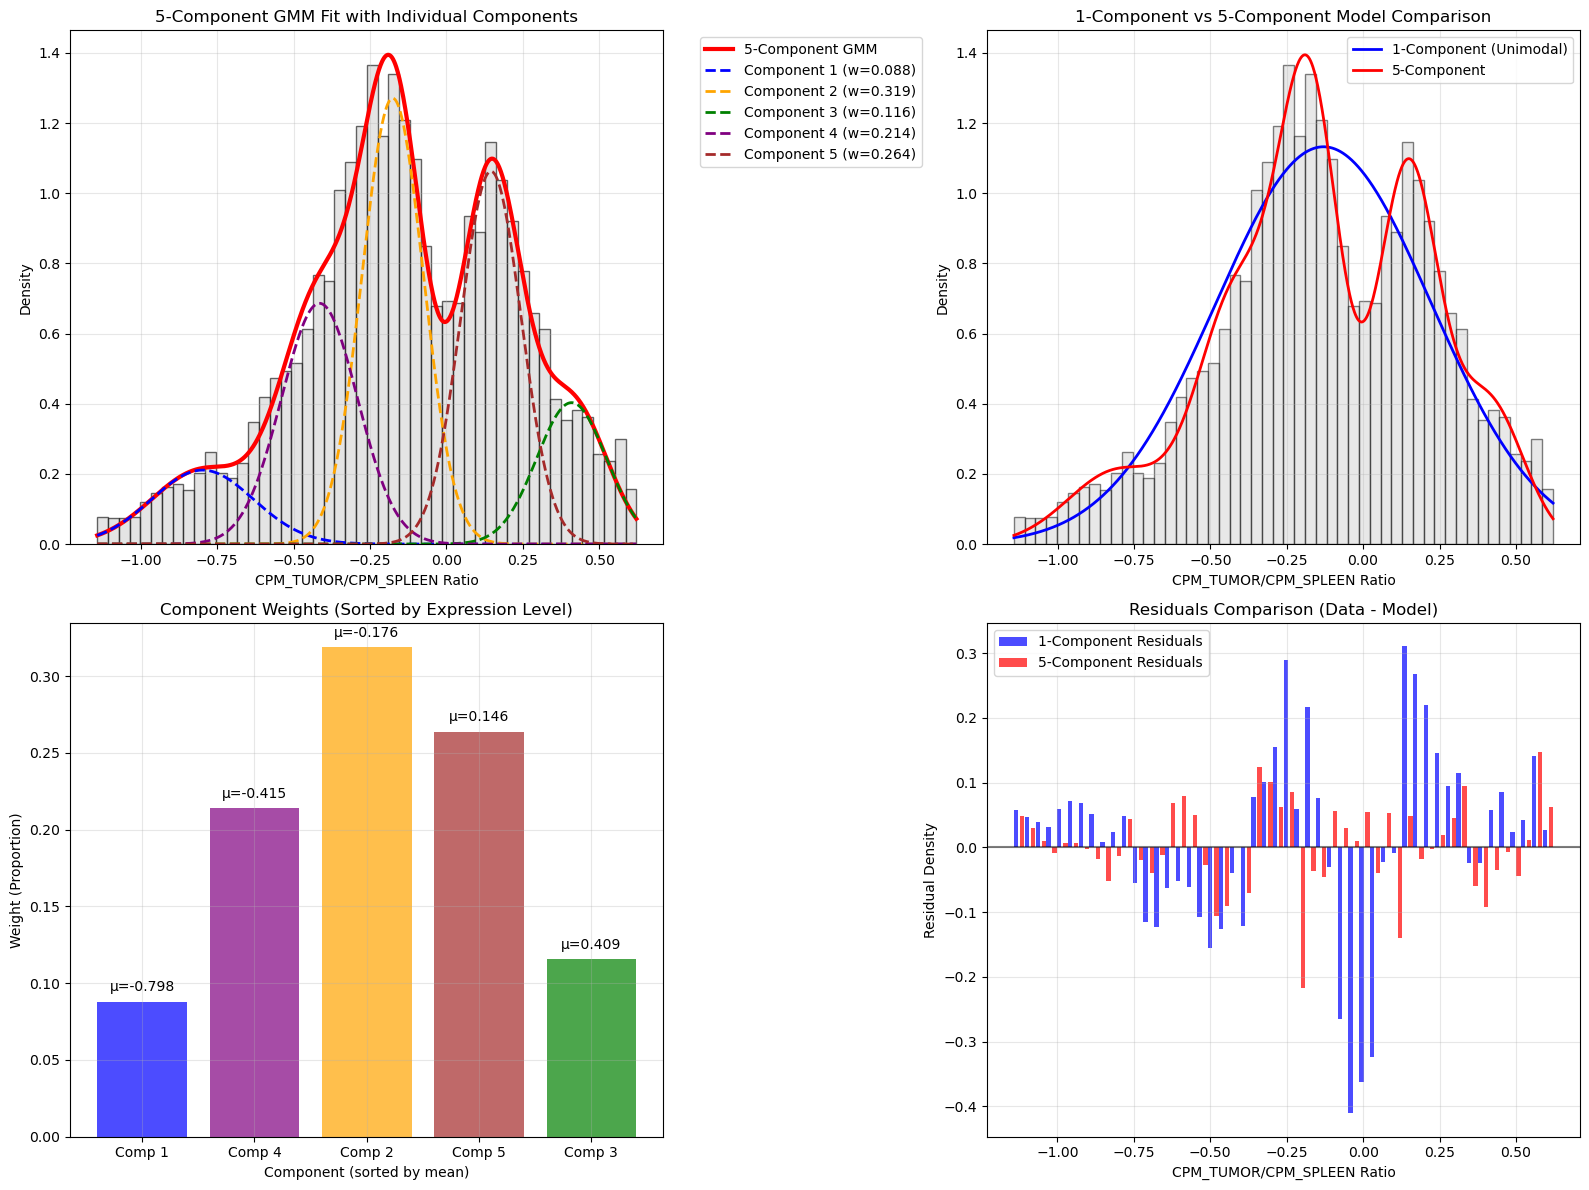


Residual Analysis:
RMSE (1-component): 0.147491
RMSE (5-component): 0.066666
Improvement: 54.8% reduction in RMSE

Component Rankings (by mean expression ratio):
Very Low Expression (Component 1): mean=-0.798, weight=8.8%
Low Expression (Component 4): mean=-0.415, weight=21.4%
Moderate Expression (Component 2): mean=-0.176, weight=31.9%
High Expression (Component 5): mean=0.146, weight=26.4%
Very High Expression (Component 3): mean=0.409, weight=11.6%


In [84]:
# Comprehensive 5-Component Model Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000).reshape(-1, 1)
x_range_1d = x_range.flatten()

# Plot 1: 5-Component GMM Fit with Individual Components
axes[0, 0].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')
gmm5_pdf = np.exp(gmm_5.score_samples(x_range))
axes[0, 0].plot(x_range_1d, gmm5_pdf, 'r-', linewidth=3, label='5-Component GMM')

# Plot individual components
colors = ['blue', 'orange', 'green', 'purple', 'brown']
responsibilities_5 = gmm_5.predict_proba(x_range)
for i in range(5):
    component_pdf = responsibilities_5[:, i] * gmm5_pdf
    axes[0, 0].plot(x_range_1d, component_pdf, '--', linewidth=2, color=colors[i],
                   label=f'Component {i+1} (w={gmm_5.weights_[i]:.3f})')

axes[0, 0].set_title('5-Component GMM Fit with Individual Components')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Compare 1-component vs 5-component
axes[0, 1].hist(ratio_1d, bins=50, density=True, alpha=0.5, color='lightgray', edgecolor='black')
gmm1_pdf = np.exp(gmm_1.score_samples(x_range))
axes[0, 1].plot(x_range_1d, gmm1_pdf, 'b-', linewidth=2, label='1-Component (Unimodal)')
axes[0, 1].plot(x_range_1d, gmm5_pdf, 'r-', linewidth=2, label='5-Component')
axes[0, 1].set_title('1-Component vs 5-Component Model Comparison')
axes[0, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Component characteristics (means and weights)
# Sort components by mean for better visualization
component_order = np.argsort([gmm_5.means_[i][0] for i in range(5)])
sorted_means = [gmm_5.means_[i][0] for i in component_order]
sorted_weights = [gmm_5.weights_[i] for i in component_order]
sorted_colors = [colors[i] for i in component_order]
component_names = [f'Comp {i+1}' for i in component_order]

bars = axes[1, 0].bar(range(5), sorted_weights, color=sorted_colors, alpha=0.7)
axes[1, 0].set_xlabel('Component (sorted by mean)')
axes[1, 0].set_ylabel('Weight (Proportion)')
axes[1, 0].set_title('Component Weights (Sorted by Expression Level)')
axes[1, 0].set_xticks(range(5))
axes[1, 0].set_xticklabels(component_names)
axes[1, 0].grid(True, alpha=0.3)

# Add mean values as text
for i, (mean, weight) in enumerate(zip(sorted_means, sorted_weights)):
    axes[1, 0].text(i, weight + 0.005, f'μ={mean:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Residuals comparison (1-component vs 5-component)
hist_counts, bin_edges = np.histogram(ratio_1d, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

gmm1_at_bins = np.exp(gmm_1.score_samples(bin_centers.reshape(-1, 1)))
gmm5_at_bins = np.exp(gmm_5.score_samples(bin_centers.reshape(-1, 1)))

residuals_1 = hist_counts - gmm1_at_bins
residuals_5 = hist_counts - gmm5_at_bins

axes[1, 1].bar(bin_centers - 0.01, residuals_1, width=np.diff(bin_edges)[0]*0.4, 
              alpha=0.7, color='blue', label='1-Component Residuals')
axes[1, 1].bar(bin_centers + 0.01, residuals_5, width=np.diff(bin_edges)[0]*0.4, 
              alpha=0.7, color='red', label='5-Component Residuals')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 1].set_title('Residuals Comparison (Data - Model)')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Residual Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate residual statistics
rmse_1 = np.sqrt(np.mean(residuals_1**2))
rmse_5 = np.sqrt(np.mean(residuals_5**2))

print(f"\nResidual Analysis:")
print(f"RMSE (1-component): {rmse_1:.6f}")
print(f"RMSE (5-component): {rmse_5:.6f}")
print(f"Improvement: {((rmse_1 - rmse_5) / rmse_1 * 100):.1f}% reduction in RMSE")

# Display component rankings
print(f"\nComponent Rankings (by mean expression ratio):")
expression_levels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
for i, (comp_idx, mean_val, weight) in enumerate(zip(component_order, sorted_means, sorted_weights)):
    print(f"{expression_levels[i]} Expression (Component {comp_idx+1}): mean={mean_val:.3f}, weight={weight:.1%}")
